In [2]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path='weights/icon_detect/best.pt'
model_path='weights/icon_detect_v1_5/model_v1_5.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [3]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
import util.utils
importlib.reload(util.utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence_v2", device=device)



Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [19]:
# run on cpu!!!
# reload utils
import importlib
import util.utils
importlib.reload(util.utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'
# image_path = 'imgs/mobile.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.8}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time()
print('ocr time:', cur_time_ocr - start)
print('caption time:', cur_time_caption - cur_time_ocr)


image size: (1919, 1079)

0: 736x1280 115 icons, 6.2ms
Speed: 4.2ms preprocess, 6.2ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 126 49
time to get parsed content: 0.24608397483825684
ocr time: 0.34783124923706055
caption time: 0.4676783084869385


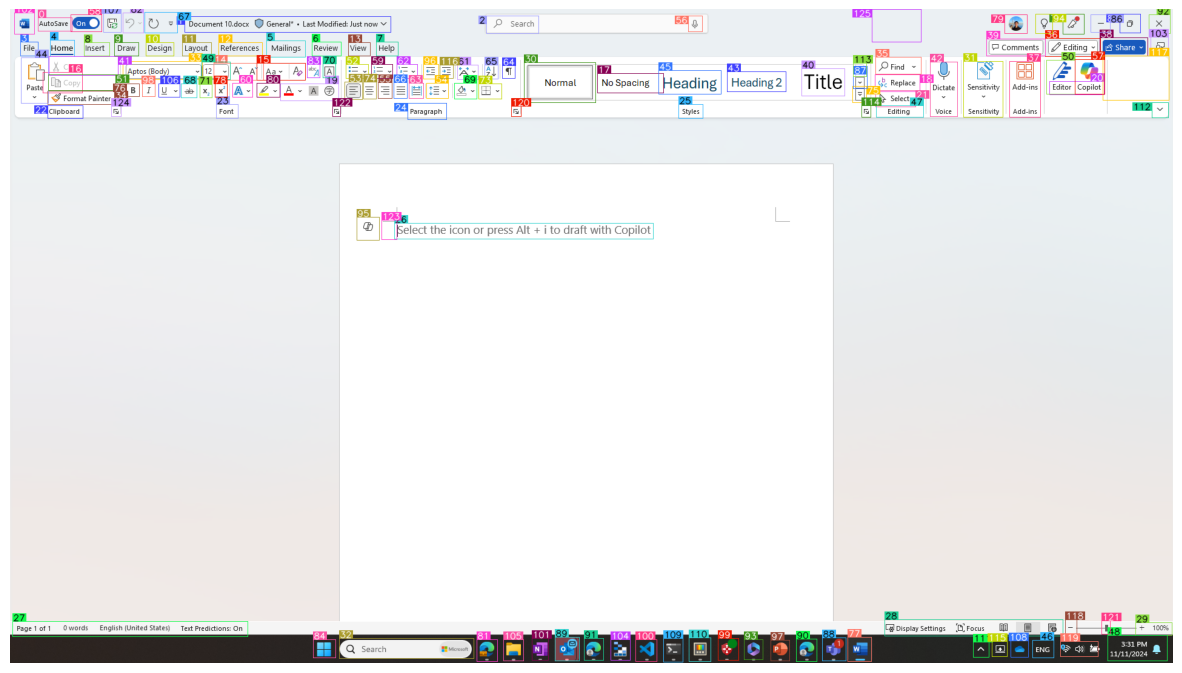

In [20]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [21]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.023970818147063255, 0.012974976561963558, 0...",False,AutoSave,box_ocr_content_ocr,0
1,text,"[0.1500781625509262, 0.011121409013867378, 0.3...",False,Document 10.docx General* Last Modified: Jus...,box_ocr_content_ocr,1
2,text,"[0.4095883369445801, 0.011121409013867378, 0.4...",False,O Search,box_ocr_content_ocr,2
3,text,"[0.009379885159432888, 0.05004633963108063, 0....",False,File,box_ocr_content_ocr,3
4,text,"[0.034392911940813065, 0.04726598784327507, 0....",False,Home,box_ocr_content_ocr,4
...,...,...,...,...,...,...
121,icon,"[0.9390129446983337, 0.9358046650886536, 0.946...",True,Adding a new item or element.,box_yolo_content_yolo,121
122,icon,"[0.27768561244010925, 0.14850999414920807, 0.2...",True,Paragraph Options,box_yolo_content_yolo,122
123,icon,"[0.3195086717605591, 0.3229200839996338, 0.332...",True,a blank space.,box_yolo_content_yolo,123
124,icon,"[0.08737725764513016, 0.14849473536014557, 0.0...",True,Paragraph Options,box_yolo_content_yolo,124


In [29]:
parsed_content_list[97]

{'type': 'icon',
 'bbox': [0.6540431380271912,
  0.9651435613632202,
  0.6705886721611023,
  0.9966893792152405],
 'interactivity': True,
 'content': 'PowerPoint',
 'source': 'box_yolo_content_yolo'}